
# Determine 16" Long Fit Analysis
### Summary: Create long fit for 16" tires since TTC data doesn't exist for them

Task 1 -> Compare 20" to 18" tires to see if the change in tire size accompanies change in output forces
 1) Investigate long force vs slip ratio at maximum comparible normal loads on 20" and 18" tires
 2) Investigate lat force vs slip angle at maximum comparible normal loads on 20" and 18" tires
 3) Investigate comparison of lat & long forces on 18" tires
Results -> Long and lat data trend very similar, so comparison is OK

Task 2 -> Create 16" long data from 18" long data
 1) Determine % difference between 16" and 18" lateral data
 2) Determine slip_ratio to slip_angle scaling factor so % difference in lateral data can be applied to long
 2) Apply % difference to 18" long data to create 16" long data
 4) Export data


In [1]:
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.append("../")
import data_helpers

### Define sweep parameters and tires to examine - default camber, pressure, and velocity selected

In [2]:
tires = {"hoosier_r25b_20-5x7_13x7":{"long":None, "lat":None},
         "hoosier_r25b_18x7-5_10x7":{"long":None, "lat":None},
         "hoosier_r25b_16x7-5_10x7":{"long":None, "lat":None}}

camber = 0 # default camber
pressure = 12* 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
run_num = 1

### Import tire data

In [3]:
for name, tire in tires.items():
    try:
        df = data_helpers.import_data(sio.loadmat(f"../tire_data/new_processed_data/braking_{name}_run{run_num}.mat"))
        tire["long"] = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["slip"] == slip_angle))]
    except:
        print("Error getting long data for {0}".format(name))
    try:
        df = data_helpers.import_data(sio.loadmat(f"../tire_data/new_processed_data/cornering_{name}_run{run_num}.mat"))
        tire["lat"] = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber))]
    except:
        print("Error getting lateral data for {0}".format(name))

Error getting long data for hoosier_r25b_16x7-5_10x7


### Verify long data correctly classified

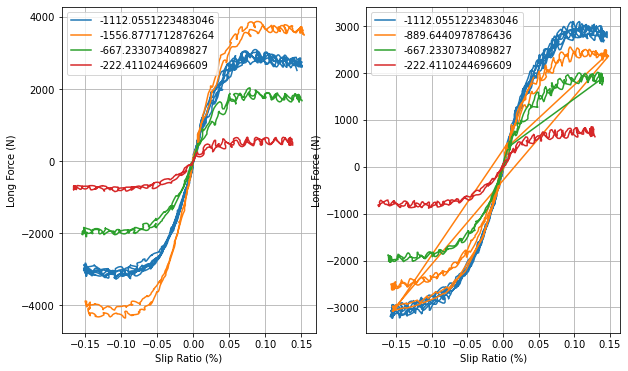

In [4]:
fig = plt.figure(figsize=(10,6))
count = 0
for name, tire in tires.items():
    if tire["long"] is not None:
        count += 1
        fig.add_subplot(1, 2, count)
        for load in tire["long"]["load"].unique():
            temp_df = tire["long"][tire["long"]["load"] == load]
            plt.plot(temp_df["SL"], temp_df["FX"], label = load)
        plt.legend()
        plt.ylabel("Long Force (N)")
        plt.xlabel("Slip Ratio (%)")
        plt.grid(True)
plt.show()

### Compare 18" to 20" Tire Long Data

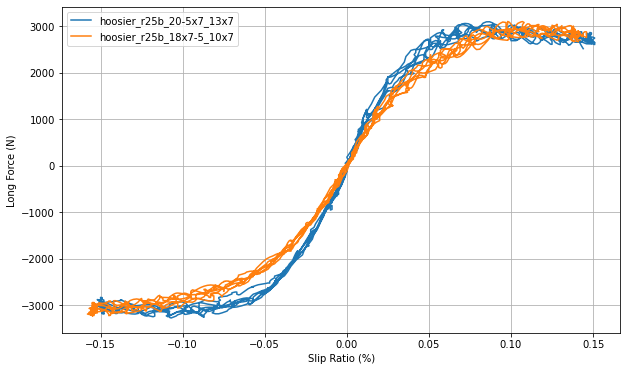

In [5]:
fig = plt.figure(figsize=(10,6))
target_load = -250/0.224809
for name, tire in tires.items():
    if tire["long"] is not None:
        temp_df = tire["long"][tire["long"]["load"] == target_load]
        plt.plot(temp_df["SL"], temp_df["FX"], label = name)
plt.legend()
plt.ylabel("Long Force (N)")
plt.xlabel("Slip Ratio (%)")
plt.grid(True)
plt.show()

### Verify classification of Lateral Tire Data

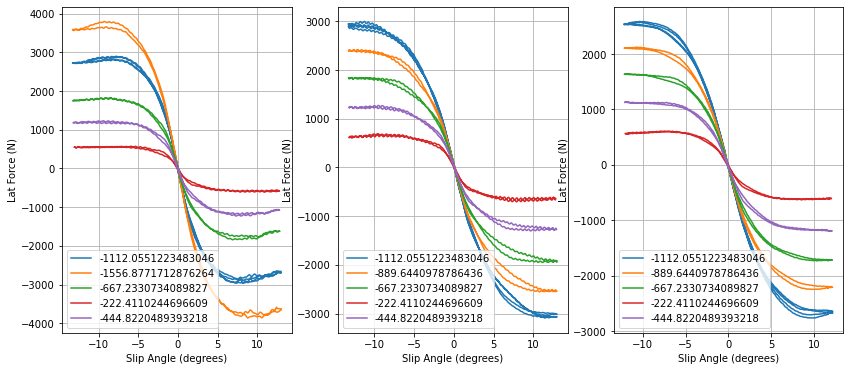

In [6]:
fig = plt.figure(figsize=(14,6))
count = 0
for name, tire in tires.items():
    if tire["lat"] is not None:
        count += 1
        fig.add_subplot(1, 3, count)
        for load in tire["lat"]["load"].unique():
            temp_df = tire["lat"][tire["lat"]["load"] == load]
            plt.plot(temp_df["SA"], temp_df["FY"], label = load)
        plt.legend()
        plt.ylabel("Lat Force (N)")
        plt.xlabel("Slip Angle (degrees)")
        plt.grid(True)
plt.show()

### Compare lateral data between 16", 18" and 20" tires

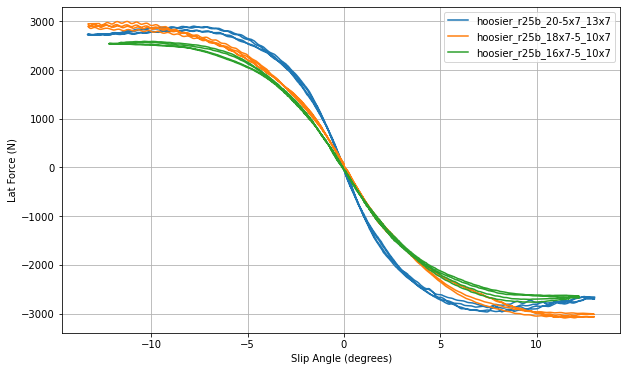

In [7]:
fig = plt.figure(figsize=(10,6))
target_load = -250/0.224809
for name, tire in tires.items():
    if tire["lat"] is not None:
        temp_df = tire["lat"][tire["lat"]["load"] == target_load]
        plt.plot(temp_df["SA"], temp_df["FY"], label = name)
plt.legend()
plt.ylabel("Lat Force (N)")
plt.xlabel("Slip Angle (degrees)")
plt.grid(True)
plt.show()

# Compare long to lateral data for same normal load; slip ratio scaled

Text(0.5, 0, 'Deflection Scaled')

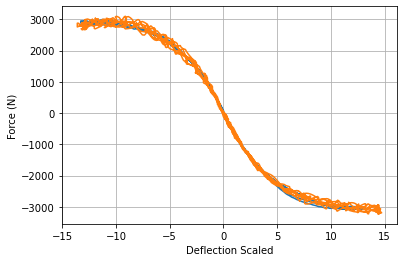

In [8]:
tire = "hoosier_r25b_18x7-5_10x7"
df_lat = tires[tire]["lat"][tires[tire]["lat"]["load"] == target_load]
df_long = tires[tire]["long"][tires[tire]["long"]["load"] == target_load]
plt.plot(df_lat["SA"], df_lat["FY"])
plt.plot(df_long["SL"]*-93.15, df_long["FX"])
plt.grid()
plt.ylabel("Force (N)")
plt.xlabel("Deflection Scaled")

# Find best scaling factor for slip ratio to slip angle

X intercept (SCALING FACTOR): 93.15384615384616


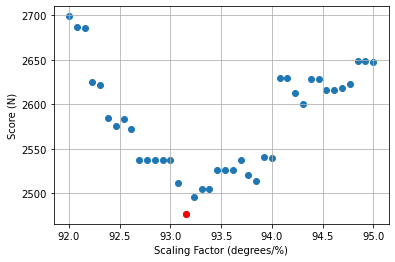

In [9]:
# optimizing for F_lat(slip_angle) = F_long(slip_angle / b)
def optimize_slip_ratio(ratio):
    slip_ratio_max = 0.15
    slip_angle_max = 12
    max_slip_angle = slip_angle_max if slip_ratio_max > slip_angle_max / ratio[0] else slip_ratio_max * ratio[0]
    slip_sweep = np.linspace(-max_slip_angle, max_slip_angle, int(12*4*12/max_slip_angle))
    slip_ratio = slip_sweep / ratio[0]
    # get average lateral force per slip angle
    lat_force = np.array([])
    for x in slip_sweep:
        lat_force = np.append(lat_force, [abs(df_lat[(df_lat["SA"] < x + 0.1) & (df_lat["SA"] > x - 0.1)]["FY"].mean())])
    long_force = np.array([])
    for x in slip_ratio:
        long_force = np.append(long_force, [abs(df_long[(df_long["SL"] < x + 0.005) & (df_long["SL"] > x - 0.005)]["FX"].mean())])
    return sum(abs(lat_force-long_force))

X = np.linspace(92, 95, 40)
Y = np.array([optimize_slip_ratio([x]) for x in X])
plt.scatter(X, Y)
plt.grid(True)
plt.ylabel("Score (N)")
plt.xlabel("Scaling Factor (degrees/%)")
scaling_factor = X[Y.argmin()]
plt.scatter([scaling_factor], [Y.min()], color = 'r')
print("X intercept (SCALING FACTOR):", scaling_factor)

### Find % Difference between 16" and 18" lateral data

In [22]:
df_columns = ["load", "slip_angle", "percent_different", "lateral_force"]
difference_df = pd.DataFrame(columns=df_columns)

for load in tires["hoosier_r25b_16x7-5_10x7"]["lat"]["load"].unique():
    df_load_1 = tires["hoosier_r25b_18x7-5_10x7"]["lat"][tires["hoosier_r25b_18x7-5_10x7"]["lat"]["load"] == load]
    df_load_3 = tires["hoosier_r25b_16x7-5_10x7"]["lat"][tires["hoosier_r25b_16x7-5_10x7"]["lat"]["load"] == load]
    
    # because mapping is slip angle limited and not slip ratio limited; do this
    past_difference = 0
    slip_angle_sign_negative = True
    for slip_angle in np.linspace(df_load_1["SA"].min(), df_load_1["SA"].max(), 50): 
        avg_force_1 = df_load_1[(df_load_1["SA"] < slip_angle + 0.2) & (df_load_1["SA"] > slip_angle - 0.2)]["FY"].mean()
        avg_force_3 = df_load_3[(df_load_3["SA"] < slip_angle + 0.2) & (df_load_3["SA"] > slip_angle - 0.2)]["FY"].mean()
        # ignore low slip angles; tends to have error and noise
        # thinking to apply general % at 3 SA to all SA below 3
        if abs(slip_angle) < 3.5:
            if slip_angle_sign_negative and slip_angle >= 0:
                slip_angle_sign_negative = False
                past_difference *= -1
            percent_difference = past_difference
        else:
            if avg_force_1 is None or avg_force_3 is None:
                percent_difference = past_difference
            else:
                percent_difference = abs(avg_force_1 - avg_force_3) / avg_force_1
                past_difference = percent_difference
                
        percent_difference = past_difference
        difference_df = difference_df.append(pd.DataFrame(np.array([[load, slip_angle, percent_difference, avg_force_3]]), columns = df_columns)) 

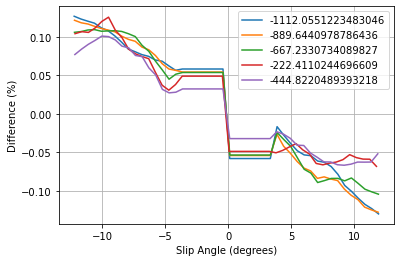

In [23]:
for load in difference_df["load"].unique():
    temp_df = difference_df[difference_df["load"] == load]
    plt.plot(temp_df["slip_angle"], temp_df["percent_different"], label = load)
plt.grid(True)
plt.legend()
plt.ylabel("Difference (%)")
plt.xlabel("Slip Angle (degrees)")
plt.show()

### Fabrication time :)

In [24]:
column_names = ["SL", "FX", "load", "velocity", "pressure", "camber", "slip", "NFX"]
export_df = pd.DataFrame(columns = column_names)
for index, row in difference_df.iterrows():
    slip_ratio = row["slip_angle"] / scaling_factor
    temp_df = tires["hoosier_r25b_18x7-5_10x7"]["long"][tires["hoosier_r25b_18x7-5_10x7"]["long"]["load"] == row["load"]]
    
    long_force = temp_df[(temp_df["SL"] < slip_ratio + 0.005) & (temp_df["SL"] > slip_ratio - 0.005)]["FX"].mean()
    
    long_force_scaled = long_force * (1 - abs(row["percent_different"]))
    
    export_df = export_df.append(pd.DataFrame(np.array([[
        slip_ratio, long_force_scaled, row["load"], velocity,
        pressure, camber, 0, long_force_scaled/row["load"]]]), columns = column_names))

### Verification of results :))

Text(0.5, 0, 'Slip Ratio (%)')

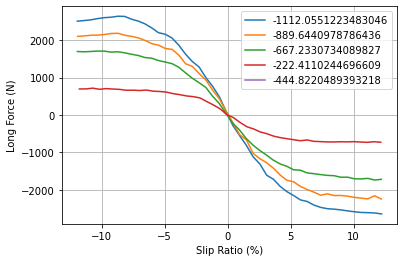

In [18]:
for load in export_df["load"].unique(): 
    temp_df = export_df[export_df["load"] == load]
    plt.plot(temp_df["SL"] * -scaling_factor, temp_df["FX"], label = load)
    
    #df_load_3 = tires["hoosier_r25b_16x7-5_10x7"]["lat"][tires["hoosier_r25b_16x7-5_10x7"]["lat"]["load"] == load]
    #plt.plot(df_load_3["SA"], df_load_3["FY"])
plt.grid(True)
plt.legend()
plt.ylabel("Long Force (N)")
plt.xlabel("Slip Ratio (%)")

### Exporting Results

In [25]:
data_helpers.export_dataframe_to_mat("../tire_data/new_processed_data/braking_hoosier_r25b_16x7-5_10x7_fabricated.mat", export_df)